In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_cosmology import p
from dset import get_dataloader, load_pretrained_model
from dset import get_validation

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_2dfilts, get_wavefun, low_to_high
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# peakcounting
from peak_counting import PeakCount, ModelPred, rmse

In [3]:
p.lamL1wave = 0.01
p.lamL1attr = 0.0
p.init_factor = 1.0
p.noise_factor = 0.0
p.const_factor = 0.0
p.wave = 'db5'
p.mode = 'zero'
p.J = 4

In [4]:
# load data and model
train_loader, test_loader = get_dataloader(p.data_path, 
                                           img_size=p.img_size[2],
                                           split_train_test=True,
                                           batch_size=p.batch_size)  

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)    

# prepare model
np.random.seed(p.seed)
torch.manual_seed(p.seed) 

wt = DWT2d(wave=p.wave, mode=p.mode, J=p.J, 
           init_factor=p.init_factor, 
           noise_factor=p.noise_factor,
           const_factor=p.const_factor).to(device)
wt.train()

# check if we have multiple GPUs
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)        
    wt = torch.nn.DataParallel(wt)        

# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=p.lr)
loss_f = get_loss_f(lamlSum=p.lamlSum, lamhSum=p.lamhSum, lamL2norm=p.lamL2norm, lamCMF=p.lamCMF, lamConv=p.lamConv, lamL1wave=p.lamL1wave, lamL1attr=p.lamL1attr)
trainer = Trainer(model, wt, optimizer, loss_f, target=p.target, 
                  use_residuals=True, attr_methods=p.attr_methods, device=device, n_print=5)      


In [17]:
# run
trainer(train_loader, epochs=50)   

Starting Training Loop...
Train Epoch: 0 [19900/20000 (100%)]	Loss: 0.972400
====> Epoch: 0 Average train loss: 0.9719
Train Epoch: 5 [19900/20000 (100%)]	Loss: 0.946272
====> Epoch: 5 Average train loss: 0.9719
Train Epoch: 10 [19900/20000 (100%)]	Loss: 0.970056
====> Epoch: 10 Average train loss: 0.9719
Train Epoch: 15 [19900/20000 (100%)]	Loss: 1.030015
====> Epoch: 15 Average train loss: 0.9719
Train Epoch: 20 [19900/20000 (100%)]	Loss: 0.949288
====> Epoch: 20 Average train loss: 0.9719


KeyboardInterrupt: 

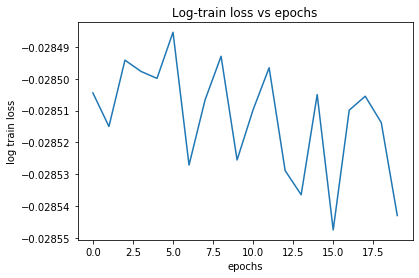

In [18]:
plt.plot(np.log(trainer.train_losses[:20]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

Reconstruction error=0.00273


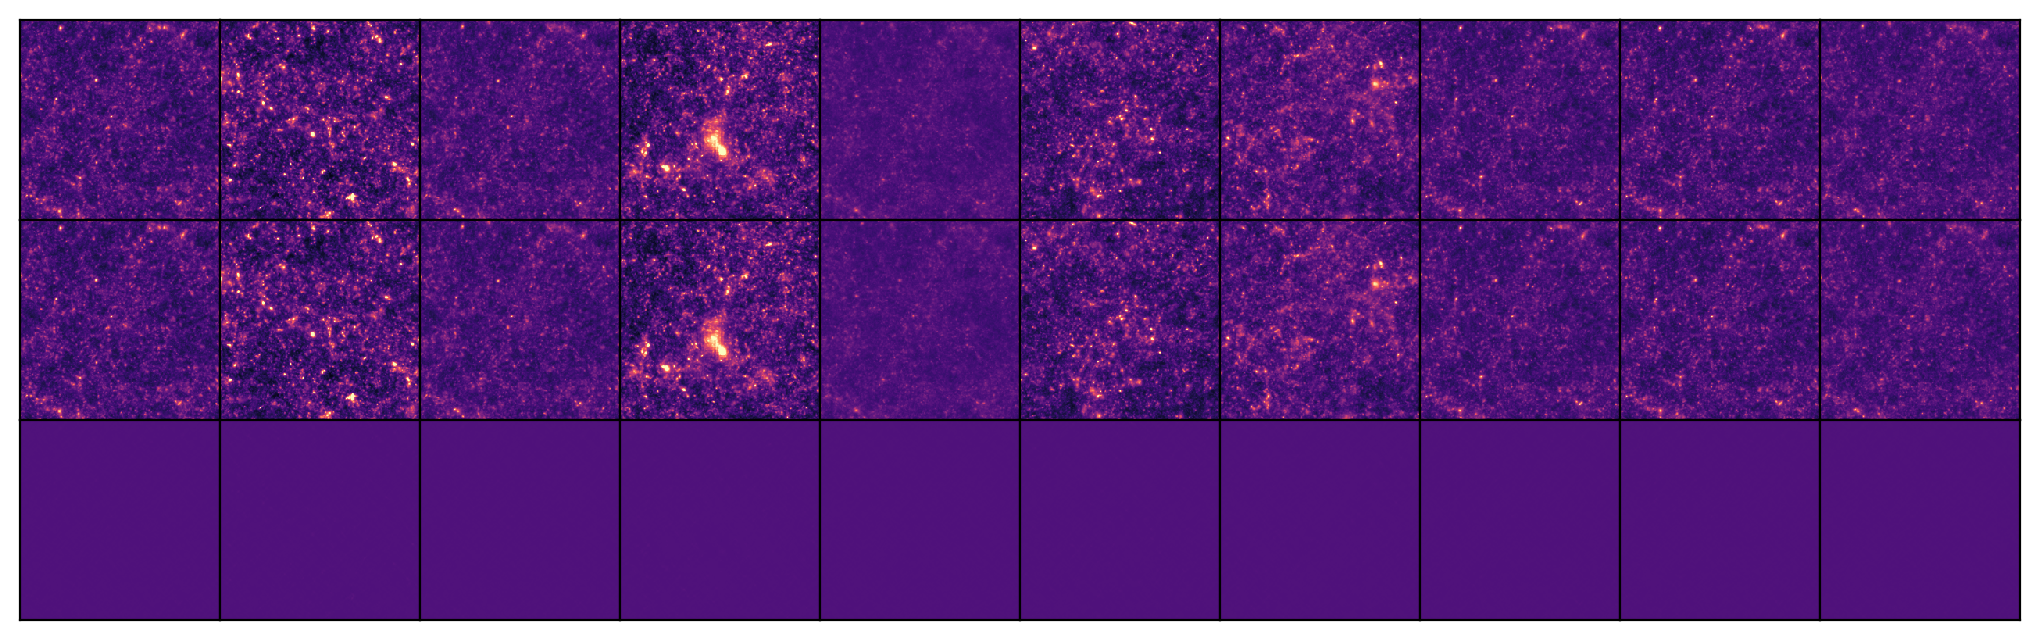

In [19]:
data = iter(test_loader).next()[0].to(device)
data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))

# get 1d wavelet filters
filt = get_2dfilts(wt)
# plot original and reconstruction images
plot_2dreconstruct(data, recon)

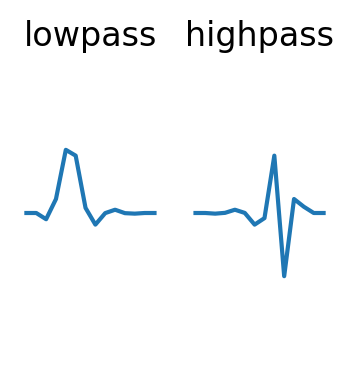

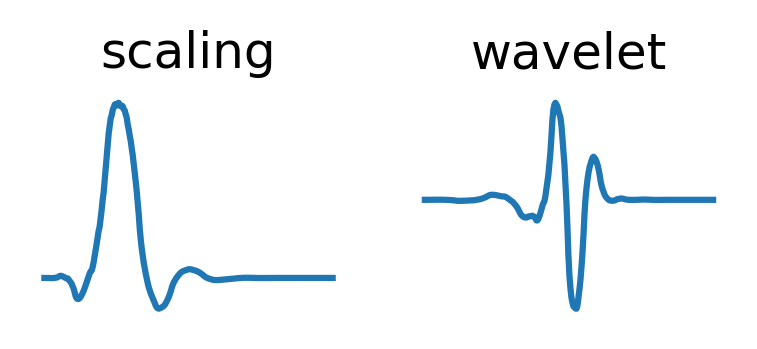

In [20]:
# original wavelet
filt = get_2dfilts(wt)
phi, psi, x = get_wavefun(wt)

plot_1dfilts(filt[0], is_title=True, figsize=(2,2))

plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))